In [285]:
# V5 -> Adicao de Clima Atual no momento do estacionamento, baseado em dataset de cidades americanas:
#https://www.kaggle.com/selfishgene/historical-hourly-weather-data?select=weather_description.csv

# Variáveis Iniciais do Sistema
initial_date = "01-01-2019"
final_date = "31-12-2020"

# Regioes e Locais cadastrados no sistemas de SmartParking
parkings_data = [
    {
        "parking": "UTFPR",
        "regions": [
            {
                "name": "Guarita",
                "open_time": "07:30",
                "close_time": "22:59",
                "max_slots": 250,
                
                #"ocuppation_avg": 0.4,
                #"ocuppation_variation": 0.25,
                
                "parking_time_min": 5,
                "parking_time_average": 240,
                "parking_time_max": 600,
                
                "weekday_flow": 1.0,
                "weekend_flow": 0.25,
                
                #"rainy flow": 0.7,
                #"sunny flow": 1.0,
                #"weather_rain_chance": 0.05,
                
                "months_flow": {
                    "January": 0.65,
                    "February": 0.75,
                    "March": 1.1,
                    "April": 1.0,
                    "May": 1.0,
                    "June": 1.0,
                    "July": 0.9,
                    "August": 0.6,
                    "September": 1.1,
                    "October": 1.0,
                    "November": 1.0,
                    "December": 0.85
                },
                
                "holidays_flow": [
                    {"date": "01-01", "flow": 0.2 },
                    {"date": "10-04", "flow": 0.4 },
                    #{"date": "11-04", "flow": 0.6 },
                    {"date": "12-04", "flow": 0.4 },
                    #{"date": "20-04", "flow": 0.6 },
                    {"date": "21-04", "flow": 0.4 },
                    {"date": "01-05", "flow": 0.4 },
                    #{"date": "02-05", "flow": 0.6 },
                    #{"date": "04-05", "flow": 0.5 },
                    #{"date": "05-05", "flow": 0.5 },
                    #{"date": "06-05", "flow": 0.5 },
                    #{"date": "07-05", "flow": 0.5 },
                    #{"date": "08-05", "flow": 0.5 },
                    #{"date": "09-05", "flow": 0.5 },
                    {"date": "11-06", "flow": 0.4 },
                    #{"date": "12-06", "flow": 0.6 },
                    #{"date": "13-06", "flow": 0.6 },
                    {"date": "07-09", "flow": 0.4 },
                    #{"date": "14-09", "flow": 0.6 },
                    {"date": "15-09", "flow": 0.5 },
                    {"date": "12-10", "flow": 0.4 },
                    #{"date": "13-10", "flow": 0.6 },
                    #{"date": "14-10", "flow": 0.6 },
                    #{"date": "15-10", "flow": 0.6 },
                    #{"date": "16-10", "flow": 0.6 },
                    #{"date": "17-10", "flow": 0.6 },
                    {"date": "28-10", "flow": 0.4 },
                    {"date": "02-11", "flow": 0.4 },
                    {"date": "15-11", "flow": 0.4 },
                    {"date": "25-12", "flow": 0.2 },
                ],
                
                "year_increase_flow_max": 0.15,
                "year_decrease_flow_max": 0.08,
                
                "rush_range": [
                    {
                        "start": "7:50",
                        "finish": "8:20",
                        "flow": 2.6
                    },
                    {
                        "start": "09:50",
                        "finish": "10:20",
                        "flow": 1.7
                    },
                    {
                        "start": "13:00",
                        "finish": "13:50",
                        "flow": 2.3
                    },
                    {
                        "start": "15:15",
                        "finish": "15:40",
                        "flow": 1.5
                    },
                    {
                        "start": "17:50",
                        "finish": "18:30",
                        "flow": 1.3
                    },
                    
                ]
            }
        ]
    }
]

In [286]:
# Importações de Bibliotecas Necessárias
import pandas as pd
import numpy as np
import time

from datetime import datetime
from datetime import timedelta  

from random import seed
from random import randint
from random import uniform

from matplotlib import pyplot as plt
import seaborn as sns

import matplotlib.dates as md

In [287]:
cols = ["parking","region","timeFrom","timeTo","weekday","spotWanted","spotWon"]

date = datetime.strptime(initial_date, '%d-%m-%Y')
end_date = datetime.strptime(final_date, '%d-%m-%Y')

for park in parkings_data:
    for region in park['regions']:
        region['open_time'] = datetime.strptime(region['open_time'], '%H:%M').time()
        region['close_time'] = datetime.strptime(region['close_time'], '%H:%M').time()
        for holyday in region['holidays_flow']:
            holyday['date'] =  datetime.strptime(holyday['date'], '%d-%m').date()
        for rush in region['rush_range']:
            rush['start'] = datetime.strptime(rush['start'], '%H:%M').time()
            rush['finish'] = datetime.strptime(rush['finish'], '%H:%M').time()

print("Start Generating On:", date.strftime('%d-%m-%Y'))
print("Finish Generating On:", end_date.strftime('%d-%m-%Y'))
days_total = (end_date - date).days
print("Total Days: ", days_total)

Start Generating On: 01-01-2019
Finish Generating On: 31-12-2020
Total Days:  730


In [288]:
df = pd.DataFrame(columns=cols)

start_time = time.time()
print("Generating Data...\n")

# Zera a lista do estacionamento
parkings = []

# Verifica se o horario atual é um horário de maior fluxo para aquela região    
def is_rush_time(region):
    is_rush = False
    rush_increase = 1
    for rush in region['rush_range']:
        # Verifica se esta no horario de pico do Rush
        if (date.time() >= rush['start'] and date.time() <= rush['finish']):
            is_rush = True
            rush_increase = rush['flow']
            break
        # Verifica se esta à pelo menos 30 minutos antes do Rush (pre-rush)
        elif ( (date + timedelta(minutes=30)).time() >= rush['start'] and (date + timedelta(minutes=30)).time() <= rush['finish'] ):
            is_rush = True
            rush_increase = ((rush['flow'] - 1) / 2) + 1
            # Cria variacao de 15 porcento para mais ou menos (para nao gerar um padrao identico de pré/pós rush)
            last_variation = uniform(-0.1,0.1)
            rush_increase = rush_increase * (1-last_variation)
            break
        # Verifica se esta à pelo menos 30 minutos depois do Rush (pós-rush)
        elif ( (date - timedelta(minutes=30)).time() >= rush['start'] and (date - timedelta(minutes=30)).time() <= rush['finish'] ):
            is_rush = True
            rush_increase = ((rush['flow'] - 1) / 2) + 1
            # Cria variacao de 15 porcento para mais ou menos (para nao gerar um padrao identico de pré/pós rush)
            last_variation = uniform(-0.1,0.1)
            rush_increase = rush_increase * (1-last_variation)
            break   
              
        # Increase Some More Parkings When Nearing to the rush time and Increase Some Parkings time after the end rush's time
        #else if (date.time())
    return is_rush, rush_increase

# Define quantos parkings serao criados em cada execucao dependendo se a regiao esta ou nao em horario de maior fluxo
def add_parkings_by_rush(region):
    is_rush, rush_increase = is_rush_time(region)
    
    add_parkings = randint(1,24)
    if (is_rush):
        # Multiplicacao do anterior OU randint(1,3*increase) *****************
        add_parkings = add_parkings * rush_increase
        #add_parkings = randint(1,int(3*rush_increase))
        
    return add_parkings

# Verifica se é dia de semana / final de semana
def check_weekday(date):
    day = date.strftime('%A')
    if day == "Saturday" or day == "Sunday":
        return 0
    return 1

# Percorre cada Parking cadastrado
for park in parkings_data:
    var_parking = park['parking']
    print("Generating Data for Parking: ",var_parking)
    # Percorre cada Região do parking
    for region in park['regions']:
        var_region = region['name']
        print("\tGenerating Data for Region: ",var_region, " ...")
        
        # Obtem os horarios de abertura e fechamento da Região do Parking
        open_time = region['open_time']
        close_time = region['close_time']
        
        # Obtem o tempo minimo e maximo de estacionamentos no local
        parking_time_min = region['parking_time_min']
        parking_time_max = region['parking_time_max']
        parking_time_average = region['parking_time_average']
        if (parking_time_min == None):
            parking_time_min = 15
        if (parking_time_max == None):
            parking_time_max = 300
        if (parking_time_average == None):
            parking_time_average = 60
            
        # Zera lista de spots ocupados no estacionamento
        parking_spots = []
        parking_max_slots = region['max_slots']
        parking_empty_slots = parking_max_slots
        
        for c in range(parking_max_slots):
            parking_spots.append(None)
        
        # Zera a data de inicio e fim para iniciar a criacao de dados
        date = datetime.strptime(initial_date, '%d-%m-%Y')
        date = date.replace(hour=open_time.hour, minute=open_time.minute)
        
        end_date = datetime.strptime(final_date, '%d-%m-%Y')
        end_date = end_date.replace(hour=close_time.hour, minute=close_time.minute)  
        
        rushs = 0
        notrushs = 0
        
        weekday_flow = region['weekday_flow']
        weekend_flow = region['weekend_flow']
        months_flow = region['months_flow']
        
        year_increase_flow_max = region['year_increase_flow_max']
        year_decrease_flow_max = region['year_decrease_flow_max']
        current_year = date.year
        cumulative_year_ratio = 1

        while(date <= end_date):
            
            # Define o percentual de vagas que serao adicionados (inicial 1 = 100%)
            parking_ratio = 1
            
            # [1 - Variaveis de Padronizacao] Calcula Impacto de horarios de alto fluxo (Rush Hours)
            check_rush,rush_increase = is_rush_time(region)
            if (check_rush):
                parking_ratio = parking_ratio * rush_increase

            # [2 - Variaveis de Padronizacao] Calcula Impacto do Fim de Semana (WeekDays/WeekendDays)
            is_weekday = check_weekday(date)
            if (is_weekday == 1):
                parking_ratio = parking_ratio * weekday_flow               
            else:
                parking_ratio = parking_ratio * weekend_flow

            # [3 - Variaveis de Padronizacao] Calcula Impacto do Clima Atual (Rainy/Sunny)


            # [4 - Variaveis de Padronizacao] Calcula o Impacto de Feriados (Holidays)
            is_holiday = 0
            for holiday in region['holidays_flow']:
                holiday_date = holiday['date']
                holiday_flow = holiday['flow']
                if (date.day == holiday_date.day and date.month == holiday_date.month):
                    parking_ratio = parking_ratio * holiday_flow * (1 + uniform(-0.1, 0.1))
                    is_holiday = 1
                
            # [5 - Variaveis de Padronizacao] Calcula o Impacto do MES ATUAL no fluxo
            current_month = months_flow[date.strftime('%B')]
            parking_ratio = parking_ratio * current_month * (1-uniform(-0.15,0.15))
            
            # [6 - Variaveis de Padronizacao] Calcula o Impacto do ANO ATUAL no fluxo
            if (date.year != current_year):
                current_year = date.year
                cumulative_year_ratio = cumulative_year_ratio * (1 + uniform(year_decrease_flow_max, year_increase_flow_max))
                print("\t\tCurrent Year: ", current_year)
            parking_ratio = parking_ratio * cumulative_year_ratio
            
            # [7 - Variacao do numero de estacionamentos no fim do dia]
            if ((date + timedelta(minutes=40)).time() >= close_time):
                parking_ratio = parking_ratio * 0.8
            
            # [8 - Variacao Final para nao criar padroes obvios e repetitivos]
            last_variation = uniform(-0.1,0.1)
            bkp = parking_ratio
            parking_ratio = parking_ratio * (1-last_variation)
            
            # Insere estacionamentos na base de dados
            MAX_ADD = 4
            
            park_max = parking_time_max
            park_avg = parking_time_average
                
            # Reduz a chance de ficar mais tempo quanto mais tarde o horario de entrada no estacionamento
            if (close_time.hour - date.hour <= park_avg/60):
                parking_ratio = parking_ratio * 0.7
                
            #elif (close_time.hour - date.hour <= park_avg/75): 
            #    parking_ratio = parking_ratio * 0.5
            #elif ( close_time.hour - date.hour <= park_avg/60 ):
            #    parking_ratio = parking_ratio * 0.7
                
                #park_max = int(parking_time_max/3)
                #park_avg = int(park_avg/3)
                #dif_hours = abs(close_time.hour - date.hour)
                #if (dif_hours <= 3):
                #    park_max = int(parking_time_max/4)
                #    park_avg = int(park_avg/4)
                #    parking_ratio = parking_ratio * ( dif_hours * 0.3 )
                #elif (dif_hours > 0):
                #    parking_ratio = parking_ratio * ( dif_hours * 0.2 )
                #else:
                #    parking_ratio = parking_ratio * ( 0.1 )
            
            #elif ( close_time.hour - date.hour <= parking_time_max/60 ):
            #    park_max = int(parking_time_max/3)
            #    park_avg = int(park_avg/3)
            #    print("MID->",date.hour)
                        
            add_parkings = 0
            if (int(MAX_ADD*parking_ratio) != 0):
                add_parkings = randint(1,int(MAX_ADD*parking_ratio))
            
            while(add_parkings != 0):
                
                # Chance do estaciomamento durar: [ Ate 60min : 70%  | Acima de 60min: 30% ]
                parking_time = randint(parking_time_min,park_avg)
                if (randint(1,10) > 5):
                    parking_time = randint(park_avg,park_max)

                # Cria uma ROW
                row = {'parking': var_parking, 'region': var_region}
                row.update({'weekday': is_weekday})
                row.update({'holiday': int(is_holiday)})
                row.update({'timeFrom': date.strftime('%d-%m-%Y %H:%M')})

                # Adiciona o Role ***********************************************
                accept_parking = True
                
                validate_date = date + timedelta(minutes=parking_time)

                # Caso o tempo de estacionamento seja maior ou igual o limite do horario do estacionamento
                if (validate_date.hour >= close_time.hour and validate_date.minute >= close_time.minute) or (validate_date.hour > close_time.hour) or (validate_date.hour < open_time.hour):
                    t1 = timedelta(hours=date.hour, minutes=date.minute)
                    t2 = timedelta(hours=close_time.hour, minutes=close_time.minute)
                    new_time = int ( (t2 - t1).total_seconds() / 60 )
                                        
                    # Caso seja um estacionamento ate 15 minutos acima do limite minimo
                    if (new_time <= parking_time_min + 15):
                        if (new_time > 15):
                            new_parking_time = randint(0, (new_time-15) )
                        else:
                            new_parking_time = randint(0, (15-new_time) )
                        validate_date = date.replace(hour=close_time.hour, minute=close_time.minute) - timedelta(minutes=new_parking_time)                  
                                                   
                        set_date = date.replace(hour=validate_date.hour, minute=validate_date.minute)
                        row.update({'timeTo': set_date.strftime('%d-%m-%Y %H:%M') })
                            
                    # Caso seja um estacionamento 15 minutos ou mais acima do limite minimo
                    else:
                        new_parking_time = randint(parking_time_min, new_time-parking_time_min )
                        validate_date = date.replace(hour=close_time.hour, minute=close_time.minute) - timedelta(minutes=new_parking_time)
                        set_date = date.replace(hour=validate_date.hour, minute=validate_date.minute)                    
                        row.update({'timeTo': set_date.strftime('%d-%m-%Y %H:%M')})
                # Caso o tempo final do estacionamento esteja dentro do limite do horario
                else:
                    row.update({'timeTo': validate_date.strftime('%d-%m-%Y %H:%M')})
                    if (date.day != validate_date.day ):
                        accept_parking = False

                # ***********************************************************************************

                # [SPOT NUMBER] Encontra um SpotID vago para o usuario
                spot_found = False
                spot_id = -1

                # Define aleatoriamente um Spot de vaga "Desejado" pelo Usuario
                try_spot = randint(0,parking_max_slots-1)
                row.update({'spotWanted': try_spot})

                # Tenta encontrar em um spot disponivel de forma aleatoria por 10 tentativas
                for c in range(1,10):
                    if (parking_spots[try_spot] == None):
                        spot_found = True
                        spot_id = try_spot
                        parking_spots[spot_id] = datetime.strptime(row['timeTo'], '%d-%m-%Y %H:%M')
                        break
                    try_spot = randint(0,parking_max_slots-1)

                # Caso nao encontre em 10 tentativas aleatorias -> seleciona o primeiro disponivel em ordem crescente
                if not (spot_found):
                    for c in range(len(parking_spots)):
                        if (parking_spots[c] == None):
                            spot_id = c
                            parking_spots[spot_id] = datetime.strptime(row['timeTo'], '%d-%m-%Y %H:%M')
                            break

                row.update({'spotWon': spot_id}) 

                # Finaliza o Role ***********************************************                
                if (spot_id != -1 and accept_parking):
                    parkings.append(row)

                # Libera Espacos vagos no estacionamento
                for c in range(len(parking_spots)):
                    if (parking_spots[c] != None):
                        if (parking_spots[c] <= date):
                            parking_spots[c] = None
                            
                # 
                if (len(parkings) >= 50000):
                    print("\t\t50.000 Generated! ...")
                    df = df.append(parkings, ignore_index=True)
                    parkings = []
                            
                add_parkings -= 1
                
            addMin = randint(0,6)
            date = date + timedelta(minutes=addMin)

            # Verifica se a nova hora e data é valida
            if not(date.time() >= open_time and date.time() <= close_time):
                date = date + timedelta(days=1)
                date = date.replace(hour=open_time.hour, minute=open_time.minute)
            elif ((date + timedelta(minutes=15)).time() >= close_time):
                date = date + timedelta(days=1)
                date = date.replace(hour=open_time.hour, minute=open_time.minute)
                
            if (date >= end_date):
                break
                    
    print("\n")
    
end_time = time.time()
final_time = datetime.fromtimestamp((end_time-start_time))
final_time = final_time.replace(microsecond=0)
df = df.append(parkings, ignore_index=True)
print("\nTime Spent: ",final_time.time())
print("Done!")

Generating Data...

Generating Data for Parking:  UTFPR
	Generating Data for Region:  Guarita  ...
		50.000 Generated! ...
		50.000 Generated! ...
		50.000 Generated! ...
		Current Year:  2020
		50.000 Generated! ...
		50.000 Generated! ...
		50.000 Generated! ...
		50.000 Generated! ...
		50.000 Generated! ...



Time Spent:  00:01:02
Done!


In [289]:
df

,parking,region,timeFrom,timeTo,weekday,spotWanted,spotWon,holiday
0,UTFPR,Guarita,01-01-2019 07:32,01-01-2019 15:24,1,65,65,1.0
1,UTFPR,Guarita,01-01-2019 07:40,01-01-2019 14:05,1,196,196,1.0
2,UTFPR,Guarita,01-01-2019 07:43,01-01-2019 10:44,1,167,167,1.0
3,UTFPR,Guarita,01-01-2019 07:50,01-01-2019 11:19,1,103,103,1.0
4,UTFPR,Guarita,01-01-2019 07:50,01-01-2019 14:17,1,92,92,1.0
...,...,...,...,...,...,...,...,...
412789,UTFPR,Guarita,31-12-2020 22:37,31-12-2020 22:46,1,80,80,0.0
412790,UTFPR,Guarita,31-12-2020 22:37,31-12-2020 22:43,1,222,222,0.0
412791,UTFPR,Guarita,31-12-2020 22:42,31-12-2020 22:59,1,67,67,0.0
412792,UTFPR,Guarita,31-12-2020 22:43,31-12-2020 22:59,1,189,189,0.0


In [290]:
#print("Total Number of Parking Spaces Refused due to capacity:")
#dfx = df[df['spotWon'] == -1]
#dfx

In [306]:
print("Writing output file...")
df.to_csv('generated_dataset_v4.csv', index=False)
print("Done!")

Writing output file...
Done!


In [292]:
print("Reading CSV...")
df = pd.read_csv('generated_dataset_v4.csv')

print("Setting the Pattern in DateTime Columns...")
df['timeFrom'] = pd.to_datetime(df['timeFrom'], errors='ignore')
df['timeFrom'] = pd.to_datetime(df["timeFrom"].dt.strftime('%d-%m-%Y %H:%M'))

print("Done!")

df

Reading CSV...
Setting the Pattern in DateTime Columns...
Done!


,parking,region,timeFrom,timeTo,weekday,spotWanted,spotWon,holiday
0,UTFPR,Guarita,2019-01-01 07:32:00,01-01-2019 15:24,1,65,65,1.0
1,UTFPR,Guarita,2019-01-01 07:40:00,01-01-2019 14:05,1,196,196,1.0
2,UTFPR,Guarita,2019-01-01 07:43:00,01-01-2019 10:44,1,167,167,1.0
3,UTFPR,Guarita,2019-01-01 07:50:00,01-01-2019 11:19,1,103,103,1.0
4,UTFPR,Guarita,2019-01-01 07:50:00,01-01-2019 14:17,1,92,92,1.0
...,...,...,...,...,...,...,...,...
412789,UTFPR,Guarita,2020-12-31 22:37:00,31-12-2020 22:46,1,80,80,0.0
412790,UTFPR,Guarita,2020-12-31 22:37:00,31-12-2020 22:43,1,222,222,0.0
412791,UTFPR,Guarita,2020-12-31 22:42:00,31-12-2020 22:59,1,67,67,0.0
412792,UTFPR,Guarita,2020-12-31 22:43:00,31-12-2020 22:59,1,189,189,0.0


,parking,region,timeFrom,timeTo,weekday,spotWanted,spotWon,holiday
0,UTFPR,Guarita,2019-01-01 07:32:00,01-01-2019 15:24,1,65,65,1.0
1,UTFPR,Guarita,2019-01-01 07:40:00,01-01-2019 14:05,1,196,196,1.0
2,UTFPR,Guarita,2019-01-01 07:43:00,01-01-2019 10:44,1,167,167,1.0
3,UTFPR,Guarita,2019-01-01 07:50:00,01-01-2019 11:19,1,103,103,1.0
4,UTFPR,Guarita,2019-01-01 07:50:00,01-01-2019 14:17,1,92,92,1.0
...,...,...,...,...,...,...,...,...
412789,UTFPR,Guarita,2020-12-31 22:37:00,31-12-2020 22:46,1,80,80,0.0
412790,UTFPR,Guarita,2020-12-31 22:37:00,31-12-2020 22:43,1,222,222,0.0
412791,UTFPR,Guarita,2020-12-31 22:42:00,31-12-2020 22:59,1,67,67,0.0
412792,UTFPR,Guarita,2020-12-31 22:43:00,31-12-2020 22:59,1,189,189,0.0


In [308]:
df1 = df.copy()
df1 = df1[['timeFrom','weekday']]

print("Setting the Pattern in DateTime Columns...")
df1['timeFrom'] = pd.to_datetime(df1['timeFrom'], errors='ignore')

print("Grouping by Day...")
df1 = df1.groupby(df1['timeFrom'].dt.date).size().reset_index(name='TotalParkings')

print("Done!")
df1

Setting the Pattern in DateTime Columns...
Grouping by Day...
Done!


,timeFrom,TotalParkings
0,2019-01-01,37
1,2019-01-02,565
2,2019-01-03,573
3,2019-01-04,553
4,2019-01-05,64
...,...,...
726,2020-12-27,169
727,2020-12-28,754
728,2020-12-29,763
729,2020-12-30,786


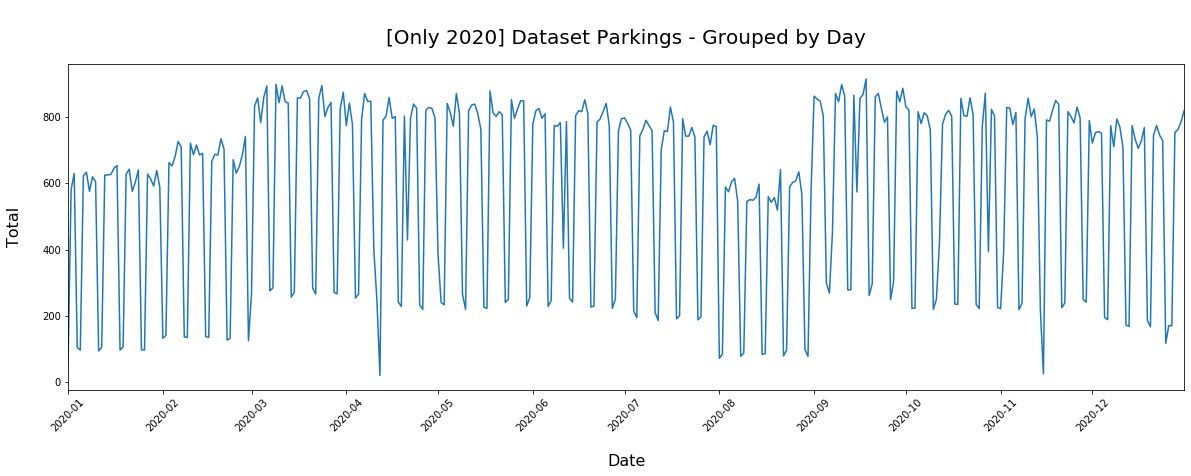

In [309]:
df4 = df1.copy()
df4['timeFrom'] = pd.to_datetime(df4['timeFrom'], errors='ignore')
df4 = df4[df4['timeFrom'].dt.year == 2020]
df4 = df4.set_index('timeFrom')

plt.subplots(figsize=(20,6))
plt.title("\n[Only 2020] Dataset Parkings - Grouped by Day", fontsize=20, pad=20)
plt.xlabel("Date", fontsize=16, labelpad=20)
plt.ylabel("Total", fontsize=16, labelpad=20)
plt.xticks(rotation=45)
plt.margins(x=0)
plt.figure(1).set_facecolor((1, 1, 1))
plt.plot(df4)

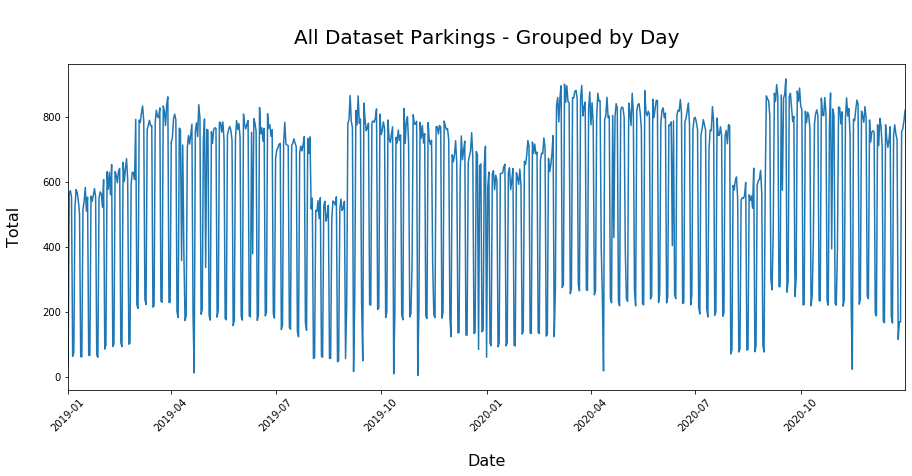

In [310]:
df3 = df1.copy()
df3 = df3.set_index('timeFrom')

plt.subplots(figsize=(15,6))

plt.title("\nAll Dataset Parkings - Grouped by Day", fontsize=20, pad=20)
plt.xlabel("Date", fontsize=16, labelpad=20)
plt.ylabel("Total", fontsize=16, labelpad=20)
plt.xticks(rotation=45)
plt.margins(x=0)
plt.figure(1).set_facecolor((1, 1, 1))
plt.plot(df3)

plt.show()

In [311]:
df2 = df1.copy()
print("Setting the Pattern in DateTime Columns...")
df2['timeFrom'] = pd.to_datetime(df2['timeFrom'], errors='ignore')

# https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases
print("Grouping by Month")
df2 = df2.groupby(pd.Grouper(freq='M', key='timeFrom')).sum().reset_index()
df2['timeFrom'] = df2['timeFrom'].dt.strftime('%m-%Y')

print("Done!")
df2

Setting the Pattern in DateTime Columns...
Grouping by Month
Done!


,timeFrom,TotalParkings
0,01-2019,12656
1,02-2019,13200
2,03-2019,19066
3,04-2019,17294
4,05-2019,18457
5,06-2019,16912
6,07-2019,17626
7,08-2019,12030
8,09-2019,18352
9,10-2019,18377


Grouping by Month


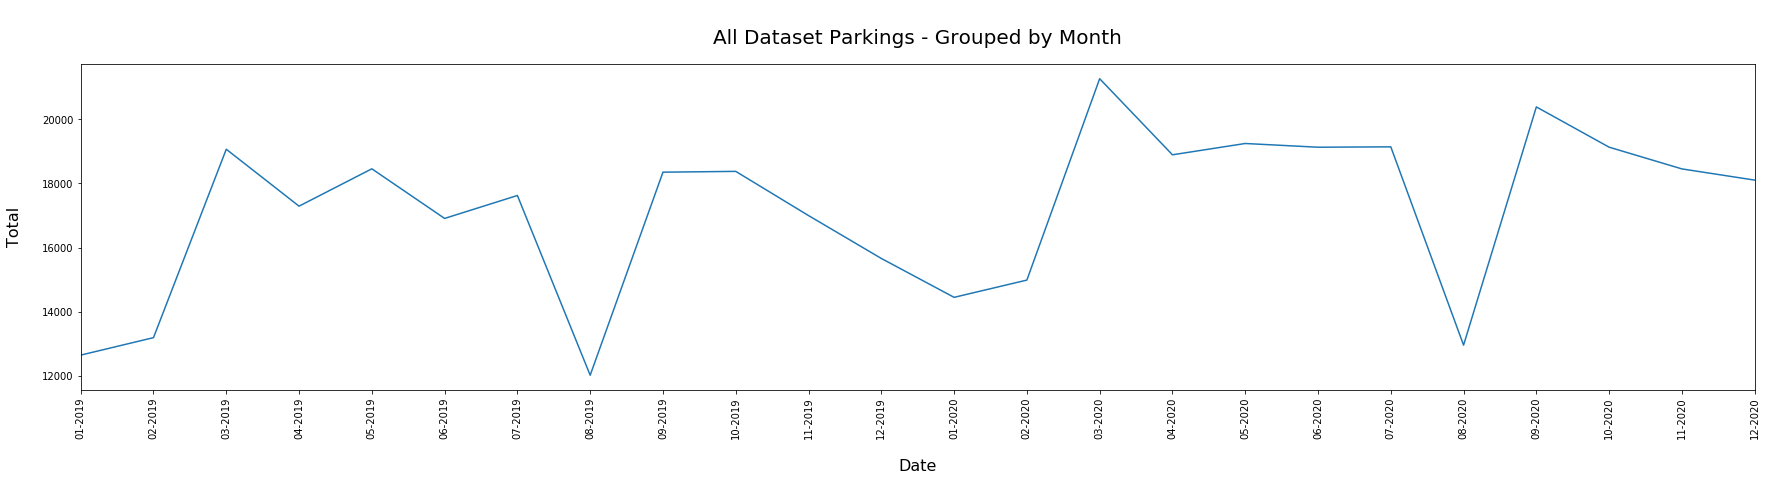

In [312]:
df3 = df2.copy()

print("Grouping by Month")
df3 = df3.set_index('timeFrom')

plt.subplots(figsize=(30,6))
plt.title("\nTotal: "+str(len(df['timeTo'])), fontsize=30, pad=20)
plt.title("\nAll Dataset Parkings - Grouped by Month", fontsize=20, pad=20)
plt.xlabel("Date", fontsize=16, labelpad=20)
plt.ylabel("Total", fontsize=16, labelpad=20)

plt.margins(x=0)
plt.figure(1).set_facecolor((1, 1, 1))
plt.xticks(rotation=90)

plt.plot(df3)

Setting Query for Specific Day and Month...
Setting the Pattern in DateTime Columns...
Generating Graph...


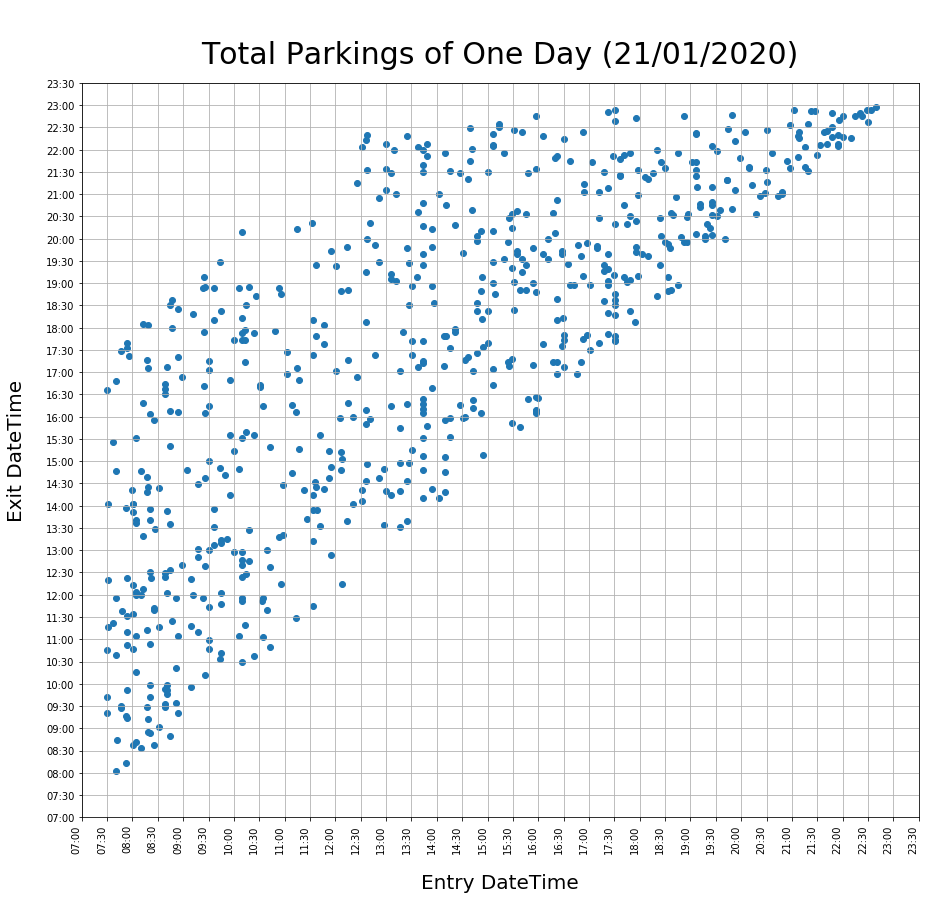

In [313]:
df4 = df.copy()
df4 = df4[['timeFrom','timeTo']]

# Query For Specific Day
print("Setting Query for Specific Day and Month...")
df4 = df4[(df4['timeFrom'].dt.month == 1) & (df4['timeFrom'].dt.day == 21) & (df4['timeFrom'].dt.year == 2020)]

if (len(df4) > 0): 
    print("Setting the Pattern in DateTime Columns...")
    df4['timeFrom'] = pd.to_datetime(df4['timeFrom'], errors='ignore')
    df4['timeFrom'] = pd.to_datetime(df4["timeFrom"].dt.strftime('%d/%m/%Y %H:%M'))

    df4['timeTo'] = pd.to_datetime(df4['timeTo'], errors='ignore')
    df4['timeTo'] = pd.to_datetime(df4["timeTo"].dt.strftime('%d/%m/%Y %H:%M'))
    print("Generating Graph...")
    fig, ax = plt.subplots(figsize=(15,15))

    max_y = 0
    min_x = 0

    while ((df4['timeTo'].max().minute + max_y) % 30 != 0):
        max_y += 1

    while ((df4['timeFrom'].min().minute + min_x) % 30 != 0):
        min_x -= 1

    min_x = min_x + 30
    max_y = max_y + 30

    plt.scatter(x=df4['timeFrom'], y=df4['timeTo'])

    ax.set_xlim(df4['timeFrom'].min()-pd.Timedelta(min_x,'m'),
                df4['timeTo'].max()+pd.Timedelta(max_y,'m'))

    ax.set_ylim(df4['timeFrom'].min()-pd.Timedelta(min_x,'m'),
                df4['timeTo'].max()+pd.Timedelta(max_y,'m'))

    ax.xaxis.set_major_locator(md.MinuteLocator(interval = 30))
    ax.xaxis.set_major_formatter(md.DateFormatter('%H:%M'))

    ax.yaxis.set_major_locator(md.MinuteLocator(interval = 30))
    ax.yaxis.set_major_formatter(md.DateFormatter('%H:%M'))

    fig.autofmt_xdate()

    plt.title("\nTotal Parkings of One Day (21/01/2020)", fontsize=30, pad=20)
    plt.xlabel("Entry DateTime", fontsize=20, labelpad=20)
    plt.ylabel("Exit DateTime", fontsize=20, labelpad=20)

    plt.xticks(rotation=90)

    plt.margins(x=0)
    plt.figure(1).set_facecolor((1, 1, 1))

    plt.grid()
    plt.show()
else:
    print("Date Not Found")

Setting Query for Specific Day and Month...
Setting the Pattern in DateTime Columns...
Grouping by Month
Done!


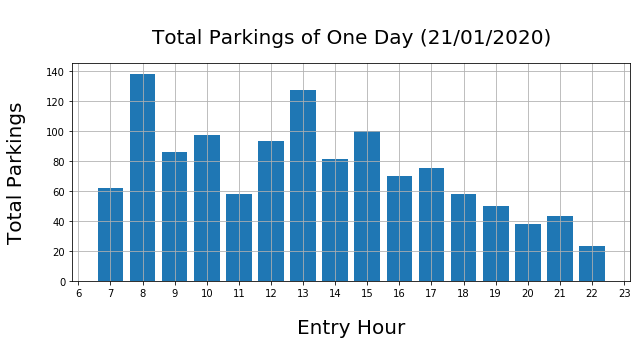

In [314]:
# Query For Specific Day
print("Setting Query for Specific Day and Month...")

df2 = df.copy()
df2 = df2.drop(df2.columns.difference(['timeFrom']), axis=1)

print("Setting the Pattern in DateTime Columns...")
df2['timeFrom'] = pd.to_datetime(df2['timeFrom'], errors='ignore')

df2 = df2[(df2['timeFrom'].dt.month == 1) & (df2['timeFrom'].dt.day == 21)]

# https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases
print("Grouping by Month")
#df2 = df2.groupby(pd.Grouper(freq='H', key='timeFrom')).sum().reset_index()

df2 = df2.groupby(df2['timeFrom'].dt.hour).size().reset_index(name='TotalParkings')

print("Done!")
df2

plt.subplots(figsize=(10,4))
plt.grid()
plt.locator_params(axis='x', nbins=24)
plt.bar(df2['timeFrom'],df2['TotalParkings'])

plt.title("\nTotal Parkings of One Day (21/01/2020)", fontsize=20, pad=20)
plt.xlabel("Entry Hour", fontsize=20, labelpad=20)
plt.ylabel("Total Parkings", fontsize=20, labelpad=20)

plt.figure(1).set_facecolor((1, 1, 1))
plt.show()

Setting the Pattern in DateTime Columns...
Grouping by Hour...


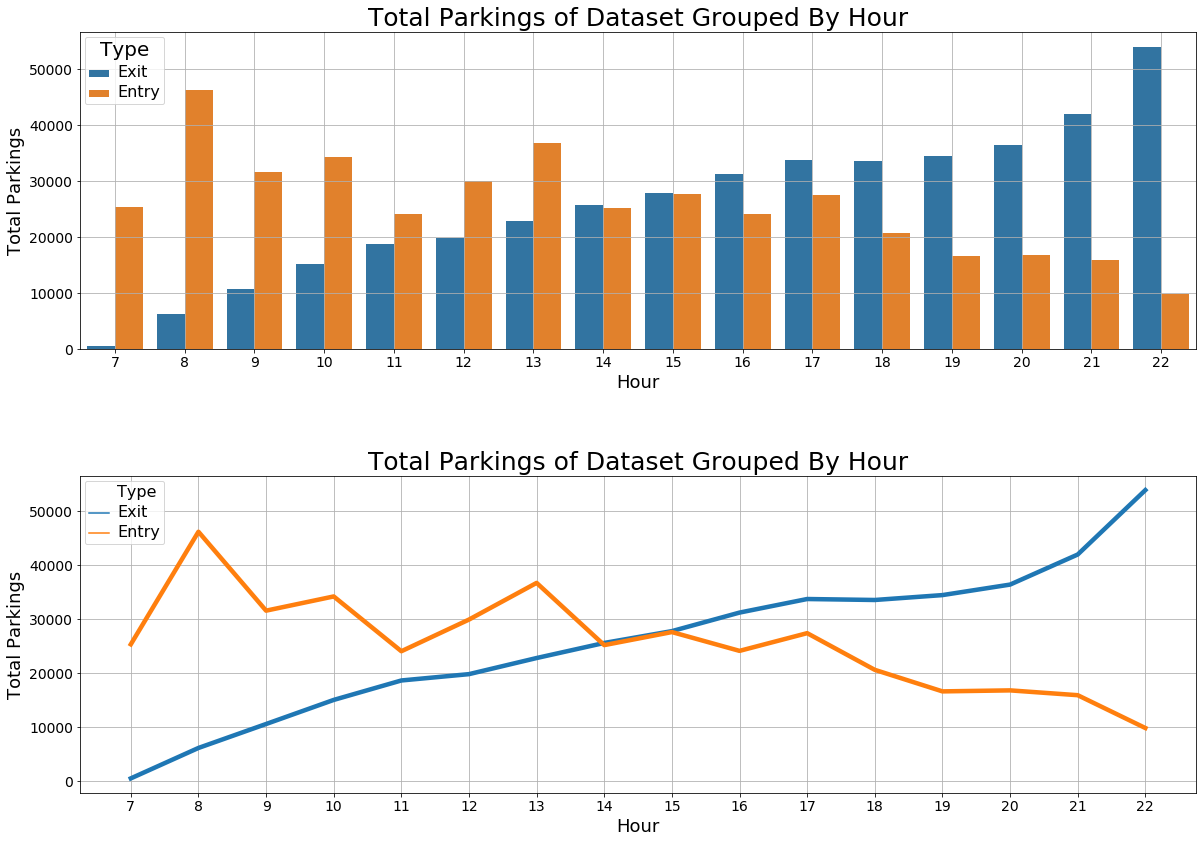

<Figure size 432x288 with 0 Axes>

In [300]:
df2 = df.copy()
df3 = df.copy()

df2 = df2.drop(df2.columns.difference(['timeTo']), axis=1)
df3 = df3.drop(df3.columns.difference(['timeFrom']), axis=1)

print("Setting the Pattern in DateTime Columns...")
df2['timeTo'] = pd.to_datetime(df2['timeTo'], errors='ignore')
df3['timeFrom'] = pd.to_datetime(df3['timeFrom'], errors='ignore')

print("Grouping by Hour...")
df2 = df2.groupby(df2['timeTo'].dt.hour).size().reset_index(name='TotalParkings')
df3 = df3.groupby(df3['timeFrom'].dt.hour).size().reset_index(name='TotalParkings')

df2 = df2.rename(columns={'timeTo':'Hour'})
df3 = df3.rename(columns={'timeFrom':'Hour'})

df3.insert(0, 'Type', 'Entry')
df2.insert(0, 'Type', 'Exit')

df2 = pd.concat([df2, df3],ignore_index=True)

fig, ax = plt.subplots(figsize=(20,14),nrows=2)
fig.subplots_adjust(hspace=0.4)

graph = sns.barplot(ax=ax[0], x = 'Hour', y='TotalParkings', hue = 'Type', data=df2)
graph.axes.set_title("Total Parkings of Dataset Grouped By Hour",fontsize=25)
graph.set_xlabel("Hour",fontsize=18)
graph.set_ylabel("Total Parkings",fontsize=18)
graph.tick_params(labelsize=14)
graph.grid()
plt.setp(graph.get_legend().get_texts(), fontsize='16') # for legend text
plt.setp(graph.get_legend().get_title(), fontsize='20') # for legend title
plt.figure(1).set_facecolor((1, 1, 1))

graph2 = sns.lineplot(ax=ax[1], x = 'Hour', y='TotalParkings', hue = 'Type', data=df2, lw=4.5)
graph2.set_xticks(range(df2['Hour'].min(),df2['Hour'].max()+1))
graph2.axes.set_title("Total Parkings of Dataset Grouped By Hour",fontsize=25)
graph2.set_xlabel("Hour",fontsize=18)
graph2.set_ylabel("Total Parkings",fontsize=18)
graph2.tick_params(labelsize=14)
graph2.grid()
plt.setp(graph2.get_legend().get_texts(), fontsize='16') # for legend text
plt.setp(graph2.get_legend().get_title(), fontsize='20') # for legend title
plt.figure(2).set_facecolor((1, 1, 1))


plt.show()

In [315]:
dfx = df.copy()
print("Grouping by SpotWon...")

xs = dfx.groupby('spotWon')['timeTo'].nunique().sort_values(ascending=False).reset_index(name='TotalWons')

xs

Grouping by SpotWon...


,spotWon,TotalWons
0,1,1874
1,0,1871
2,3,1870
3,2,1848
4,4,1830
...,...,...
245,169,1573
246,190,1565
247,232,1562
248,241,1550


In [316]:
dfx = df.copy()

wanted_equals_won = [dfx[dfx['spotWon'] == dfx['spotWanted']].count().max()][0]
wanted_dif_won = [dfx[dfx['spotWon'] != dfx['spotWanted']].count().max()][0]

print("Same Spot Wanted & Won: ",wanted_equals_won)
print("Different Spot Wanted & Won: ",wanted_dif_won)

print("\nTotal Parkings: ",wanted_equals_won+wanted_dif_won)
print("Requested/Won Sucess Rate: %0.2f%%" % ((wanted_equals_won * 100 / (wanted_equals_won+wanted_dif_won))) )

Same Spot Wanted & Won:  152412
Different Spot Wanted & Won:  260382

Total Parkings:  412794
Requested/Won Sucess Rate: 36.92%


In [303]:
df1 = df.copy()
df1 = df1[['timeFrom','weekday','holiday']]

print("Setting the Pattern in DateTime Columns...")
df1['timeFrom'] = pd.to_datetime(df1['timeFrom'], errors='ignore')

print("Grouping by Day...")
df2 = df1.groupby(df1['timeFrom'].dt.date).size().reset_index(name='TotalParkings')
df2['timeFrom'] = pd.to_datetime(df2['timeFrom'], errors='ignore')

print("Setting the Pattern in DateTime Columns (2)...")
df1['timeFrom'] = df1['timeFrom'].dt.date
df1['timeFrom'] = pd.to_datetime(df1['timeFrom'], errors='ignore')

print("Merging DataFrames...")
df3 = pd.merge(df1,df2, on='timeFrom')

print("Aggregating DataFrame Columns...")
df4 = df3.groupby(['timeFrom']).agg(['sum','count']).reset_index(drop=False)

print("Done!")

Setting the Pattern in DateTime Columns...
Grouping by Day...
Setting the Pattern in DateTime Columns (2)...
Merging DataFrames...
Aggregating DataFrame Columns...
Done!


In [304]:
# Only Holidays DataFrame
df9 = df4.copy()
df9 = df9[['timeFrom','weekday','holiday']]

only_weekdays = df9[df9['weekday']['sum'] != 0]
only_weekendDays = df9[df9['weekday']['sum'] == 0]

only_holidays = df9[df9['holiday']['sum'] != 0]
only_nonHolidays = df9[df9['holiday']['sum'] == 0]

weekdays_holidays = df9[(df9['weekday']['sum'] != 0) & (df9['holiday']['sum'] != 0)]
weekendDays_holidays = df9[(df9['weekday']['sum'] == 0) & (df9['holiday']['sum'] != 0)]

weekdays_nonHolidays = df9[(df9['weekday']['sum'] != 0) & (df9['holiday']['sum'] == 0)]
weekendDays_nonHolidays = df9[(df9['weekday']['sum'] == 0) & (df9['holiday']['sum'] == 0)]

"""
print("Parking Daily Average By:\n")
print("WeekDays: ",only_weekdays["weekday"].mean()['count'])
print("WeekEndDays: ",only_weekendDays["weekday"].mean()['count'])
print()
print("Non-Holidays: ",only_nonHolidays["holiday"].mean()['count'])
print("Holidays: ",only_holidays["holiday"].mean()['count'])
print()
print("WeekDays & Holidays: ",weekdays_holidays["weekday"].mean()['count'])
print("WeekEndDays & Holidays: ",weekendDays_holidays["weekday"].mean()['count'])
print()
print("WeekDays & Non-Holidays  ",weekdays_nonHolidays["weekday"].mean()['count'])
print("WeekEndDays & Non-Holidays: ",weekendDays_nonHolidays["weekday"].mean()['count'])
"""

dataPlot = [
    {"id":0, "data": "WeekDays", "total": only_weekdays["weekday"].mean()['count']},
    {"id":0, "data": "WeekEndDays", "total": only_weekendDays["weekday"].mean()['count']},
    {"id":1, "data": "Non-Holidays", "total": only_nonHolidays["holiday"].mean()['count']},
    {"id":1, "data": "Holidays", "total": only_holidays["holiday"].mean()['count']},
    {"id":2, "data": "WeekDays & Non-Holidays", "total": weekdays_nonHolidays["weekday"].mean()['count'] },
    {"id":2, "data": "WeekDays & Holidays", "total": weekdays_holidays["weekday"].mean()['count'] },
    {"id":3, "data": "WeekEndDays & Non-Holidays", "total": weekendDays_nonHolidays["weekday"].mean()['count']},
    {"id":3, "data": "WeekEndDays & Holidays", "total": weekendDays_holidays["weekday"].mean()['count']}
]

dfPlt = pd.DataFrame(dataPlot)
dfPlt

,id,data,total
0,0,WeekDays,720.478011
1,0,WeekEndDays,173.000000
2,1,Non-Holidays,576.387234
3,1,Holidays,247.730769
4,2,WeekDays & Non-Holidays,735.132937
5,2,WeekDays & Holidays,331.736842
6,3,WeekEndDays & Non-Holidays,178.338308
7,3,WeekEndDays & Holidays,19.714286


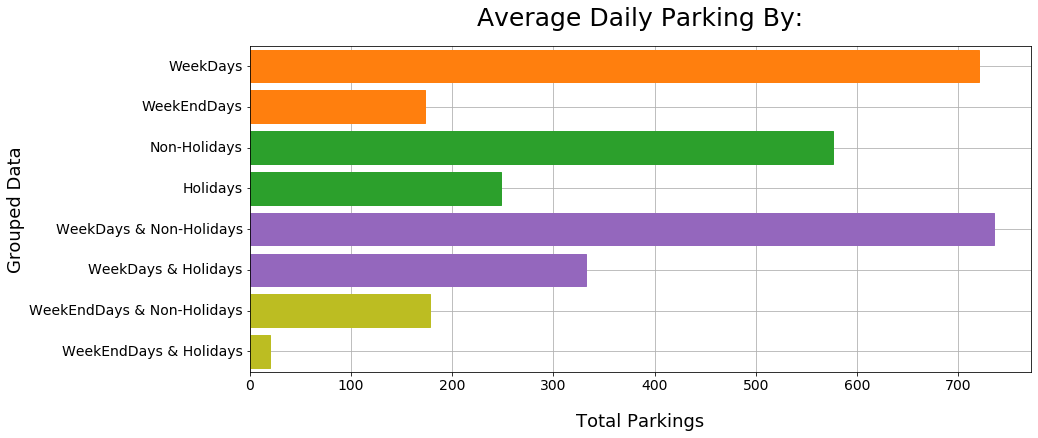

In [305]:
df2 = dfPlt.copy()

fig, ax = plt.subplots(figsize=(14,6),nrows=1)

graph = sns.barplot(ax=ax, y='data', x='total', data=df2)
#graph.axes.get_legend().remove()
graph.set_yticklabels(graph.get_yticklabels(), rotation=0, fontsize="14", va="center")
graph.axes.set_title("Average Daily Parking By:",fontsize=25, pad=20)
graph.set_xlabel("Total Parkings",fontsize=18, labelpad=20)
graph.set_ylabel("Grouped Data",fontsize=18)
graph.tick_params(labelsize=14)
graph.axes.set_axisbelow(True)
graph.grid()

cont = 0
for bar in ax.patches:
    if (cont <= 1):
        bar.set_color('C1')
    elif (cont <= 3):
        bar.set_color('C2')
    elif (cont <= 5):
        bar.set_color('C4')
    elif (cont <= 7):
        bar.set_color('C8')
    cont+=1

plt.figure(1).set_facecolor((1, 1, 1))

plt.show()